<img src="https://editor.analyticsvidhya.com/uploads/521138.png"> </img>

## VGG-11 is a convolutional neural network that specializes in processing images

## Using VGG-11 to suggest art pieces in a similar style

Given an image that you like, can we suggest pieces in a similar style? Note that this is slightly different than "given an image, can we offer images that look the same"

Artsy is an art platform with a public site that categorizes art pieces by style [here](https://www.artsy.net/categories).

<img src='../data/baroque.png'></img>

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np


In [2]:
# fine tune on style and use bert to vectorize the style name to branch out of style as well??

In [23]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

_transforms = transforms.Compose(
[
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standardization of pixel colors
])

train_dataset = datasets.ImageFolder(root='../data/artsy/train', transform=_transforms)
test_dataset = datasets.ImageFolder(root='../data/artsy/test', transform=_transforms)

batch_size = 128

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
len(train_dataset) + len(test_dataset)

55306

In [4]:
images, labels = next(iter(training_dataloader)) 
images.shape, labels.shape

(torch.Size([128, 3, 100, 100]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


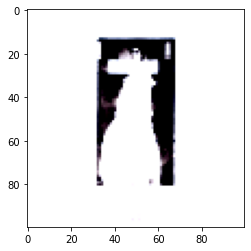

In [5]:
plt.imshow(images[0].detach().numpy().transpose(1, 2, 0))

In [6]:
vgg_model = models.vgg11(pretrained='imagenet')
vgg_model.classifier[-1].out_features

1000

In [26]:
vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1011, bias=True)
)

In [8]:
vgg_model.classifier[-1] = nn.Linear(4096, len(set(train_dataset.targets)))  # Change the final classifier layer to output 10 classes instead of 1,000

for layer in vgg_model.classifier:  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'weight'):  # Randomize all parameters in the classifier to start fresh
        torch.nn.init.xavier_uniform_(layer.weight)  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'bias'):  # Randomize all parameters in the classifier to start fresh
        nn.init.constant_(layer.bias.data, 0)  # Randomize all parameters in the classifier to start fresh

vgg_model.classifier[-1].out_features


1011

In [9]:

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)

n_epochs = 20 
print_every = 50
valid_loss_min = np.Inf
total_step = len(training_dataloader)

train_loss, val_loss, train_acc, val_acc = [], [], [], [] 


In [10]:
# code inspired from https://www.pluralsight.com/guides/introduction-to-resnet

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # A
vgg_model.train()

for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(training_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()  # clears the gradient or else they accumulate
        
        outputs = vgg_model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}%')
    
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        vgg_model.eval()
        for data_t, target_t in (testing_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = vgg_model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testing_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}%\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(vgg_model.state_dict(), 'vgg_art.pt')
            print('Saving Parameters')
            
    vgg_model.train()
    
# A set device to either cuda or cpu


Epoch 1

Epoch [1/20], Step [0/300], Loss: 8.1172
Epoch [1/20], Step [50/300], Loss: 6.9135
Epoch [1/20], Step [100/300], Loss: 6.9194
Epoch [1/20], Step [150/300], Loss: 6.9067
Epoch [1/20], Step [200/300], Loss: 6.9220
Epoch [1/20], Step [250/300], Loss: 6.8877

train-loss: 6.9090, train-acc: 0.1513%
validation loss: 6.8507, validation acc: 0.1474%

Saving Parameters
Epoch 2

Epoch [2/20], Step [0/300], Loss: 6.8493
Epoch [2/20], Step [50/300], Loss: 6.8438
Epoch [2/20], Step [100/300], Loss: 6.8708
Epoch [2/20], Step [150/300], Loss: 6.8005
Epoch [2/20], Step [200/300], Loss: 6.7979
Epoch [2/20], Step [250/300], Loss: 6.7421

train-loss: 6.8655, train-acc: 0.2034%
validation loss: 6.8111, validation acc: 0.5011%

Saving Parameters
Epoch 3

Epoch [3/20], Step [0/300], Loss: 6.7277
Epoch [3/20], Step [50/300], Loss: 6.7509
Epoch [3/20], Step [100/300], Loss: 6.7557
Epoch [3/20], Step [150/300], Loss: 6.7560
Epoch [3/20], Step [200/300], Loss: 6.7458
Epoch [3/20], Step [250/300], Loss:

KeyboardInterrupt: 

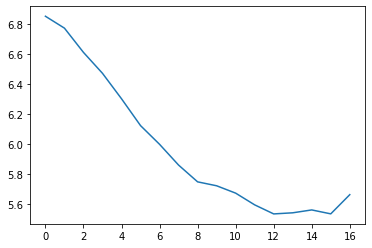

In [11]:
plt.plot(val_loss)

Text(0, 0.5, 'Accuracy %')

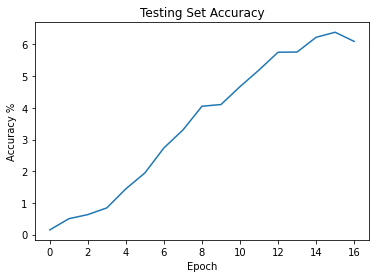

In [12]:
plt.plot(val_acc)
plt.title('Testing Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

## 2 Weeks Later

In [13]:
# Load up our imports
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np


In [14]:
# Instantiate a VGG model with our saved weights
vgg_model = models.vgg11(pretrained='imagenet')  # B
vgg_model.classifier[-1] = nn.Linear(4096, len(set(train_dataset.targets)))
vgg_model.load_state_dict(torch.load('vgg_art.pt'))

vgg_model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [15]:
# re-loading the test dataset

batch_size = 32

testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
from tqdm import tqdm

testing_embeddings = torch.zeros(len(test_dataset), 512)
with torch.no_grad():
    for index, (batch, labels) in enumerate(tqdm(testing_dataloader)):
        testing_embeddings[index*batch_size:index*batch_size+batch.shape[0],:] = vgg_model.features(batch).mean((2, 3))
    

100%|█████████████████████████████████████████| 531/531 [02:32<00:00,  3.48it/s]


In [17]:
testing_embeddings.shape

torch.Size([16963, 512])

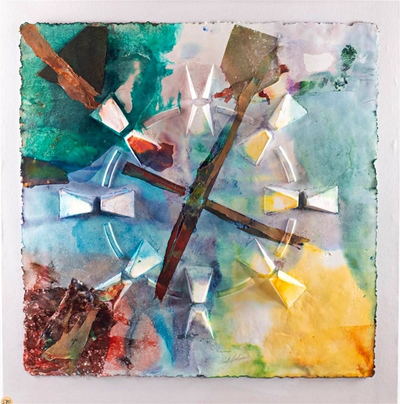

In [18]:
from PIL import Image

img = Image.open('../data/Mixed Media 3-D Collage.jpg')
img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


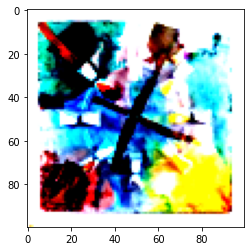

In [19]:
image_matrix = np.asarray(np.expand_dims(_transforms(img), 0))

plt.imshow(image_matrix[0].transpose(1, 2, 0))

In [20]:
# style prediction
train_dataset.classes[vgg_model(torch.tensor(image_matrix)).argmax()]

'contemporary-art'

In [21]:
top_similar_images = torch.cosine_similarity(
    vgg_model.features(torch.tensor(image_matrix)).mean((2, 3)), testing_embeddings
).argsort()[-5:].tolist()[::-1]

top_similar_images


[11018, 16899, 13935, 6755, 12661]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

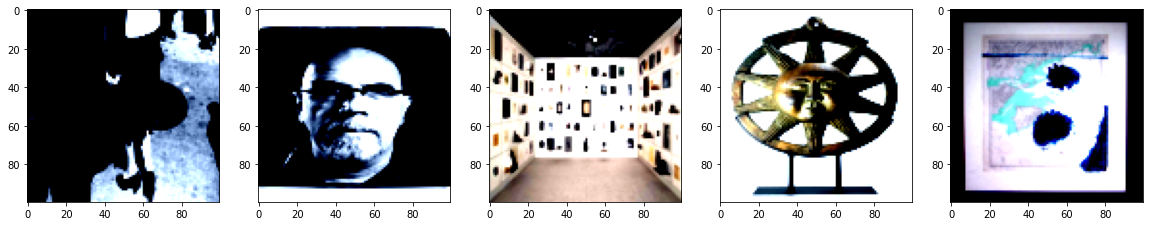

In [22]:
plt.figure()

f, axarr = plt.subplots(1, 5, figsize=(20, 10)) 
for index, top_image in enumerate(top_similar_images):
    axarr[index].imshow(test_dataset[top_image][0].detach().numpy().transpose(1, 2, 0))

# Next Steps + Considersations

1. 100 x 100 is likely not big enough to capture style properly. This was done to make training easier on CPUs
2. It would behoove us to consolidate response to a number closer to 100-300 categories to make training easier
3. We can consider other deep learning models like Resnet and the Vision Transformer
